In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
TSQL,175.656438,7.319018,15.391193,24
Finance Junk,180.460502,45.115126,73.884568,4
"Jane Eyre, Bronte",195.159745,24.394968,37.828755,8
Email Auth and Security,300.058755,50.009793,105.343349,6
Azure AD Authentication,561.346602,46.778884,114.820351,12
Logging in Python,627.566455,44.826175,83.678165,14
Debugging in VS Code,636.030376,90.861482,199.688904,7
RAG Project,650.710754,72.301195,227.162824,9
Azure Private DNS,1180.914186,62.153378,132.285538,19
C# Basics,1500.268983,48.395774,118.806415,31


# Histogram

sum of ages: ~40289.54


<Axes: >

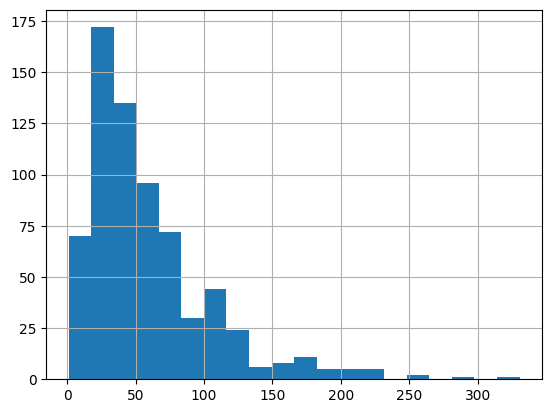

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~40289.54


<Axes: >

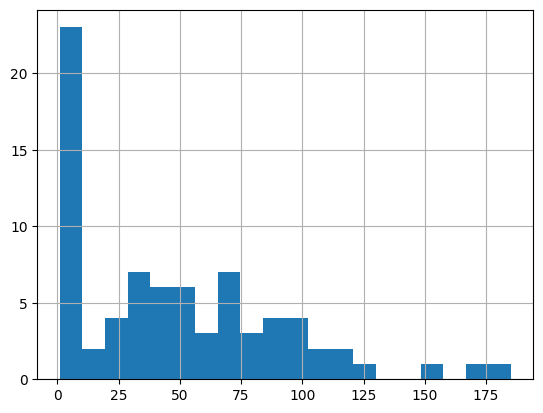

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 687
Total card age: 40289.54


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
39,Azure Developer Associate,Replicate your registry to another region usin...,63cbc67f004ff8b4757823bcd84c1692,-185.122476,48.997569,185.122476,-3772.812799,0.823646,0,0
40,Azure Developer Associate,Type of Azure Container Registry authenticatio...,479458e1b339f5153c380c9b5d3d9922,-129.594155,48.997569,185.122476,-3772.812799,0.823646,3,0
279,Azure Developer Associate,Make sure you add the period (.) to the end of...,dcd2a6970dcd4fd13e31426277eccd8b,-108.579195,48.997569,185.122476,-3772.812799,0.823646,6,0
508,Azure Developer Associate,How do you correlate errors from Application I...,d2b1cb71a345cc2e58099a4572434c25,-101.549660,48.997569,185.122476,-3772.812799,0.823646,9,0
43,Azure Developer Associate,What feature lets you validate a Linux Web App...,06cf52a8b21987984aeeda225ca20257,-92.963938,48.997569,185.122476,-3772.812799,0.823646,12,0
510,Azure Developer Associate,Which CLI command rotates a key in Azure Key V...,a51b2d0b754e4678ad97c60f8ed159e8,-84.584966,48.997569,185.122476,-3772.812799,0.823646,15,0
45,Azure Developer Associate,Which Azure Cosmos DB consistency level maximi...,324d4923f4ef46338fe659ea5cd873b2,-75.162620,48.997569,185.122476,-3772.812799,0.823646,18,0
46,Azure Developer Associate,To which storage locations can Event Hubs Capt...,77f409993de5b998d32a6a4a7b53b29f,-69.353716,48.997569,185.122476,-3772.812799,0.823646,21,0
285,Azure Developer Associate,You need to read an Azure Cosmos DB change fee...,39ca378e88ff6e0fbd6e86568b374236,-66.255223,48.997569,185.122476,-3772.812799,0.823646,24,0
286,Azure Developer Associate,Which App Service log type contains the HTML f...,f6d9770fba82f6e3cf934e8c588e405c,-63.486974,48.997569,185.122476,-3772.812799,0.823646,27,0


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [36]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
84,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,-330.686345,81.656919,330.686345,-3021.305991,0.480451,0,0
172,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-290.037262,71.699886,290.037262,-1720.797259,0.625399,0,0
111,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,-257.704885,85.396597,257.704885,-2732.691102,0.291328,0,0
65,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,-250.589984,60.380405,250.589984,-3320.922272,0.239810,0,0
163,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,-230.054742,75.050807,230.054742,-1951.320976,0.082696,0,0
205,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,-227.162824,72.301195,227.162824,-650.710754,0.100988,0,0
97,JavaScript Concepts,"Heroku: A cloud platform for deploying, managi...",81c33c8653348fa2529f220a4a2e60b1,-224.903796,70.285792,224.903796,-2881.717484,0.495891,0,0
464,Asynchronous Python,Throttling\nLimiting concurrency in Python asy...,6d8d6c93bede788bb645c334badc4faa,-217.176496,68.522985,217.176496,-2809.442397,0.503883,0,0
303,PnP PowerShell,Grant-PnPAzureADAppPermission (PnP.PowerShell)...,286cb0ddc5b9b680fc8f44ede5f20598,-216.055569,60.380405,250.589984,-3320.922272,0.239810,1,1
235,Asynchronous Python,async for (async iterator)\nUsed to iterate ov...,dbb74bcba577f12b06ddf83f9550d31b,-213.074625,68.522985,217.176496,-2809.442397,0.503883,1,1


In [39]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Replicate your registry to another region usin...
hash                   63cbc67f004ff8b4757823bcd84c1692479458e1b339f5...
age                                                          -976.652922
subject_mean_age                                              489.975688
subject_highest_age                                          1851.224763
subject_age_sum                                             -37728.12799
head_random_roll                                                8.236462
count                                                                135
n_fold                                                                 0
dtype: object

In [40]:
existing_cards['age'].mean()

-58.645617141943575